In [1]:
# %matplotlib notebook

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 80% !important; }</style>"))

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import random
import cv2

plt.style.use('seaborn-pastel')

from IPython.display import Image
from IPython.display import HTML

tf.__version__

'2.0.0'

In [387]:
def dense(size, activation):
    return tf.keras.layers.Dense(
        size,
        activation=activation,
        kernel_initializer=tf.random_normal_initializer(0, 1),
        bias_initializer=tf.random_normal_initializer(0, 1)
    )

class CPPNUV:
    def __init__(self, width, depth, mirror=False):
        self.layers = []
        self.mirror = mirror
        for i in range(depth):
            self.layers.append(dense(
                width, tf.sigmoid if i == 0 else tf.sigmoid
            ))

        # output uv map
        self.layers.append(dense(2, tf.sigmoid))

    def generate_input_mesh(self, size):
        w, h = size
        ar = w / h
        x = np.linspace(-ar / 2, ar / 2, w)
        y = np.linspace(-0.5, 0.5, h)
        
        if self.mirror:
            x = np.abs(x)
            y = np.abs(y)
        
        xx, yy = np.meshgrid(x, y)
        mesh = np.stack((xx.reshape(-1), yy.reshape(-1)), axis=-1)

        return mesh

    def generate(self, z, im_size=(128, 128)):
        mesh = self.generate_input_mesh(im_size)
        # Add z to input
        result = np.concatenate((np.tile(z, (mesh.shape[0], 1)), mesh), axis=-1)
        result = np.float32(result)

        for d in self.layers:
            result = d(result)

        img = result.numpy().reshape(*im_size[::-1], -1)
        return img

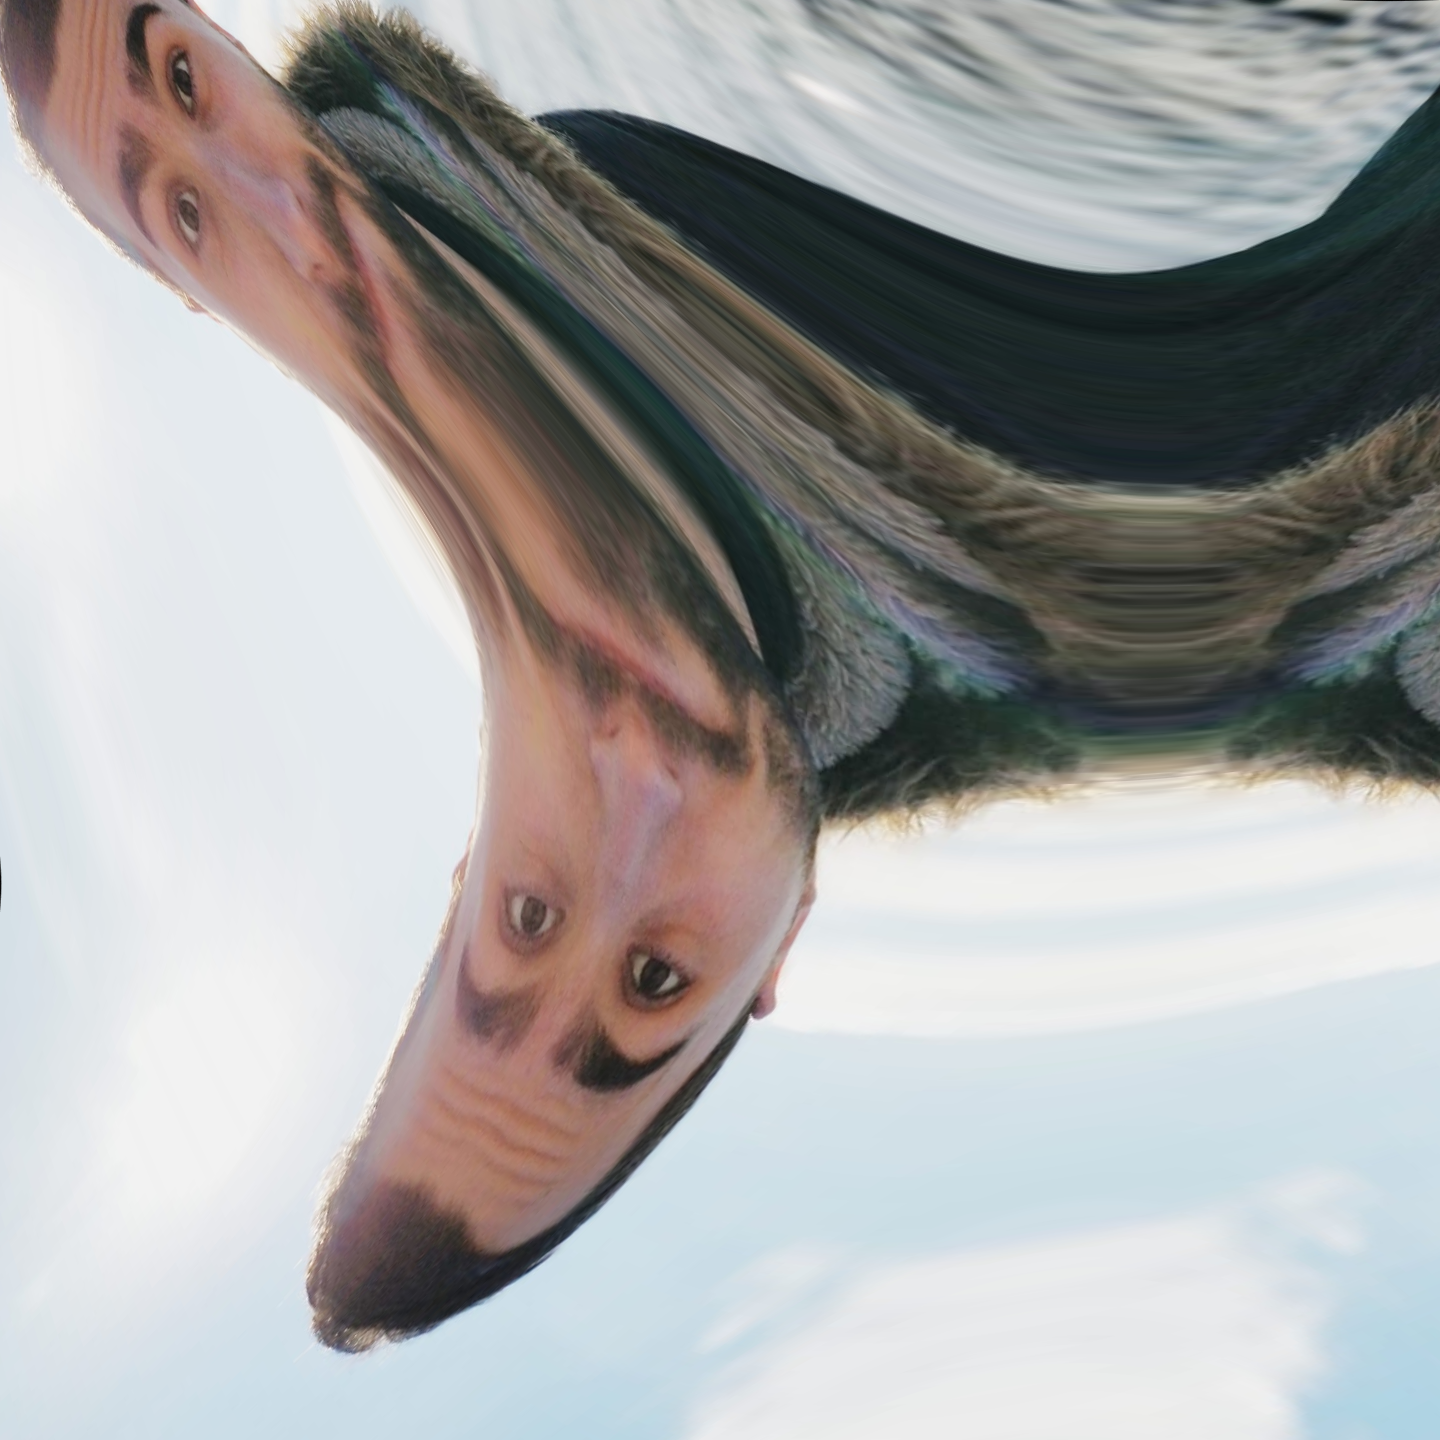

In [430]:
im = cv2.imread('avatar.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

uv = CPPNUV(30, 7, mirror=False).generate(1, im_size=(im.shape[0], im.shape[1]))
xx = uv[:, :, 0]
yy = uv[:, :, 1]

norm_xx = (xx - np.min(xx)) / (np.max(xx) - np.min(xx))
norm_yy = (yy - np.min(yy)) / (np.max(yy) - np.min(yy))


out = cv2.remap(im, norm_xx * im.shape[0], norm_yy * im.shape[1], cv2.INTER_AREA)

plt.imsave('test.png', out, format='png', cmap='Greys')
Image(filename='test.png', width=500)